In [279]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [280]:
data = pd.read_csv("Euros Group Stages.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [281]:
info = pd.read_csv("T5 Leagues Mins 23-24.csv" , low_memory=False)
info

,Unnamed: 0,player,team,age,position,Mins,Passing Accuracy
0,0,Bukayo Saka,Arsenal,22,"D(L),M(CLR)",2937,83.0
1,1,Rodri,Man City,28,"D(C),DMC",2937,92.5
2,2,Michael Olise,Crystal Palace,22,AM(CLR),1277,83.1
3,3,Kevin De Bruyne,Man City,32,"M(CLR),FW",1228,83.8
4,4,Phil Foden,Man City,24,"AM(CLR),FW",2869,89.1
...,...,...,...,...,...,...,...
2856,2856,Vignon Ouotro,Strasbourg,18,Forward,7,50.0
2857,2857,Adrian Grbic,Lorient,27,FW,31,58.3
2858,2858,Antonin Cartillier,Monaco,20,Defender,8,33.3
2859,2859,Gino Caoki,Lorient,19,Midfielder,6,66.7


In [282]:
cmap_lst = ['#131313', '#24a8ff', '#0d4163'] 
cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 

In [283]:
data['total_seconds'] = data['minute'] * 60 + data['second']

In [284]:
# Define the function to calculate TTRP
def calculate_ttrp(data):
    # Initialize the new column with NaNs
    data['TTRP'] = np.nan
    
    # Define the preceding action types
    preceding_action_types = ['Aerial', 'BallRecovery', 'Tackle', 'TakeOn', 'Interception', 'Pass']
    
    # Filter data to get relevant actions
    relevant_actions = data[data['type'].isin(preceding_action_types)].copy()
    
    # Sort the data by gameId and total_seconds to ensure proper order
    relevant_actions.sort_values(by=['gameId', 'total_seconds'], inplace=True)
    
    # Create a shift column to get the previous action's time, type, and playerId within the same game
    relevant_actions['prev_total_seconds'] = relevant_actions.groupby('gameId')['total_seconds'].shift(1)
    relevant_actions['prev_type'] = relevant_actions.groupby('gameId')['type'].shift(1)
    relevant_actions['prev_playerId'] = relevant_actions.groupby('gameId')['playerId'].shift(1)
    
    # Filter only the passes
    passes = data[data['type'] == 'Pass'].copy()
    
    # Merge passes with relevant actions to get the preceding action details
    passes = passes.merge(
        relevant_actions[['gameId', 'playerId', 'total_seconds', 'prev_total_seconds', 'prev_type', 'prev_playerId']],
        how='left',
        left_on=['gameId', 'playerId', 'total_seconds'],
        right_on=['gameId', 'playerId', 'total_seconds']
    )
    
    # Calculate TTRP for valid preceding actions
    passes['TTRP'] = np.where(
        ((passes['prev_type'] == 'Pass') & (passes['prev_playerId'] != passes['playerId'])) |
        ((passes['prev_type'] != 'Pass') & (passes['prev_playerId'] == passes['playerId'])),
        passes['total_seconds'] - passes['prev_total_seconds'],
        np.nan
    )
    
    # Merge TTRP back to the original data
    data = data.merge(passes[['gameId', 'playerId', 'total_seconds', 'TTRP']], 
                      how='left', 
                      on=['gameId', 'playerId', 'total_seconds'], 
                      suffixes=('', '_y'))
    
    # Fill TTRP column
    data['TTRP'] = data['TTRP'].combine_first(data['TTRP_y'])
    data.drop(columns=['TTRP_y'], inplace=True)
    
    return data

# Apply the function
data = calculate_ttrp(data)

In [285]:
data_passes = data[data['type'] == 'Pass']

In [286]:
data_fast_passes = data_passes[(data_passes['TTRP'] == 1) | (data_passes['TTRP'] == 2) | (data_passes['TTRP'] == 3) | (data_passes['TTRP'] == 4)
                              | (data_passes['TTRP'] == 5)]

In [287]:
data_fast_passes_succ = data_fast_passes[data_fast_passes['outcomeType'] == 'Successful']
data_fast_passes_unsucc = data_fast_passes[data_fast_passes['outcomeType'] == 'Unsuccessful']
#data_fast_passes_unsucc

In [288]:
data_fast_passes_succ_prog = data_fast_passes_succ.reset_index()
#data_unsucc_prog = data_unsucc.reset_index()
data_fast_passes_succ_prog['beginning'] = np.sqrt(np.square(120-data_fast_passes_succ_prog['x']) + np.square(40 - data_fast_passes_succ_prog['y']))
data_fast_passes_succ_prog['end'] = np.sqrt(np.square(120 - data_fast_passes_succ_prog['endX']) + np.square(40 - data_fast_passes_succ_prog['endY']))

data_fast_passes_succ_prog['progressive'] = [(data_fast_passes_succ_prog['end'][x]) / (data_fast_passes_succ_prog['beginning'][x]) < .75 for x in range(len(data_fast_passes_succ_prog.beginning))]
data_fast_passes_succ_prog = data_fast_passes_succ_prog[data_fast_passes_succ_prog['progressive'] == True]

In [289]:
data_fast_passes_succ_prog

,index,league,season,game,id,gameId,period,minute,second,expandedMinute,...,is_shot,is_goal,card_type,related_event_id,related_player_id,total_seconds,TTRP,beginning,end,progressive
0,6,INT-European Championship,2024,2024-06-14 Germany-Scotland,2696027199,1787315,FirstHalf,0,3.0,0,...,NaN,NaN,NaN,NaN,NaN,3.0,3.0,78.368820,23.313824,True
15,62,INT-European Championship,2024,2024-06-14 Germany-Scotland,2696027443,1787315,FirstHalf,3,11.0,3,...,NaN,NaN,NaN,NaN,NaN,191.0,2.0,81.053622,36.944499,True
27,100,INT-European Championship,2024,2024-06-14 Germany-Scotland,2696027631,1787315,FirstHalf,5,32.0,5,...,NaN,NaN,NaN,NaN,NaN,332.0,4.0,107.790671,59.432961,True
43,122,INT-European Championship,2024,2024-06-14 Germany-Scotland,2696027737,1787315,FirstHalf,6,45.0,6,...,NaN,NaN,NaN,NaN,NaN,405.0,3.0,55.680517,30.912548,True
46,132,INT-European Championship,2024,2024-06-14 Germany-Scotland,2696027791,1787315,FirstHalf,7,10.0,7,...,NaN,NaN,NaN,NaN,NaN,430.0,3.0,54.722865,38.122078,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24086,57211,INT-European Championship,2024,2024-06-26 Ukraine-Belgium,2697995659,1812233,SecondHalf,81,27.0,84,...,NaN,NaN,NaN,NaN,NaN,4887.0,1.0,57.945478,39.842891,True
24097,57258,INT-European Championship,2024,2024-06-26 Ukraine-Belgium,2697996069,1812233,SecondHalf,85,12.0,88,...,NaN,NaN,NaN,NaN,NaN,5112.0,1.0,73.448627,53.405992,True
24104,57275,INT-European Championship,2024,2024-06-26 Ukraine-Belgium,2697996155,1812233,SecondHalf,86,21.0,89,...,NaN,NaN,NaN,NaN,NaN,5181.0,5.0,48.665059,25.589279,True
24110,57293,INT-European Championship,2024,2024-06-26 Ukraine-Belgium,2697996251,1812233,SecondHalf,87,33.0,90,...,NaN,NaN,NaN,NaN,NaN,5253.0,5.0,45.226629,17.424810,True


In [290]:
#filtered_data = data_fast_passes_succ_prog[data_fast_passes_succ_prog['TTRP'].isin([2, 3, 4, 5])]

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame()

# Group by player and team
grouped = data_fast_passes_succ_prog.groupby(['player', 'team'])

# Count the number of progressive passes for each TTRP value
for ttrp_value in [1, 2, 3, 4, 5]:
    result_df[f'prog_pass_{ttrp_value}_sec'] = grouped.apply(lambda x: (x['TTRP'] == ttrp_value).sum()).reset_index(level=[0,1], drop=True)

# Reset the index to turn the grouped columns into normal columns
result_df.reset_index(inplace=True)

# Add player and team to the result DataFrame
result_df['player'] = grouped['player'].first().values
result_df['team'] = grouped['team'].first().values

# Reorder the columns
result_df = result_df[['player', 'team', 'prog_pass_1_sec', 'prog_pass_2_sec', 'prog_pass_3_sec', 'prog_pass_4_sec', 'prog_pass_5_sec']]


In [302]:
result_df = result_df.sort_values("prog_pass_2_sec", ascending=False)

In [304]:
result_df.head(30)

,player,team,prog_pass_1_sec,prog_pass_2_sec,prog_pass_3_sec,prog_pass_4_sec,prog_pass_5_sec
339,TONI KROOS,Germany,3,11,9,7,2
158,JOSHUA KIMMICH,Germany,2,10,4,6,2
8,ALEXANDER BAH,Denmark,1,8,3,3,0
291,PRZEMYSLAW FRANKOWSKI,Poland,0,7,4,2,2
20,ANDY ROBERTSON,Scotland,1,7,0,0,0
257,NICOLAS SEIWALD,Austria,2,6,2,1,1
189,KRISTJAN ASLLANI,Albania,2,6,1,1,0
141,JANNIK VESTERGAARD,Denmark,0,6,1,0,0
226,MAXIMILIAN MITTELSTÄDT,Germany,1,6,4,0,0
184,KIERAN TRIPPIER,England,0,6,2,0,0


In [293]:
result_df_p90 = result_df

In [294]:
result_df_p90['player'] = result_df_p90['player'].str.strip().str.upper()
info['player'] = info['player'].str.strip().str.upper()
result_df_p90 = pd.merge(result_df_p90, info, on=['player', 'team'], how='inner')

In [295]:
result_df_p90 = result_df_p90[['player', 'team', 'age', 'Mins', 'prog_pass_2_sec' , 'prog_pass_3_sec', 'prog_pass_4_sec', 'prog_pass_5_sec']]
result_df_p90['90s'] = (result_df_p90['Mins']/90).round(2)

In [296]:
result_df_p90 = result_df_p90[['player', 'team', 'age', '90s', 'prog_pass_2_sec' , 'prog_pass_3_sec', 'prog_pass_4_sec', 'prog_pass_5_sec']]

In [297]:
result_df_p90['prog_pass_2_sec_p90'] = result_df_p90['prog_pass_2_sec']/result_df_p90['90s']
result_df_p90['prog_pass_3_sec_p90'] = result_df_p90['prog_pass_3_sec']/result_df_p90['90s']
result_df_p90['prog_pass_4_sec_p90'] = result_df_p90['prog_pass_4_sec']/result_df_p90['90s']
result_df_p90['prog_pass_5_sec_p90'] = result_df_p90['prog_pass_5_sec']/result_df_p90['90s']

In [298]:
result_df_p90 = result_df_p90[['player', 'team', 'age', '90s', 'prog_pass_2_sec_p90', 'prog_pass_3_sec_p90', 'prog_pass_4_sec_p90', 'prog_pass_5_sec_p90']]

In [299]:
result_df_p90 = result_df_p90[(result_df_p90['90s'] >= 15)]

In [300]:
result_df_p90 = result_df_p90.sort_values("prog_pass_2_sec_p90", ascending=False)
disp = result_df_p90.head(20)
disp

,player,team,age,90s,prog_pass_2_sec_p90,prog_pass_3_sec_p90,prog_pass_4_sec_p90,prog_pass_5_sec_p90


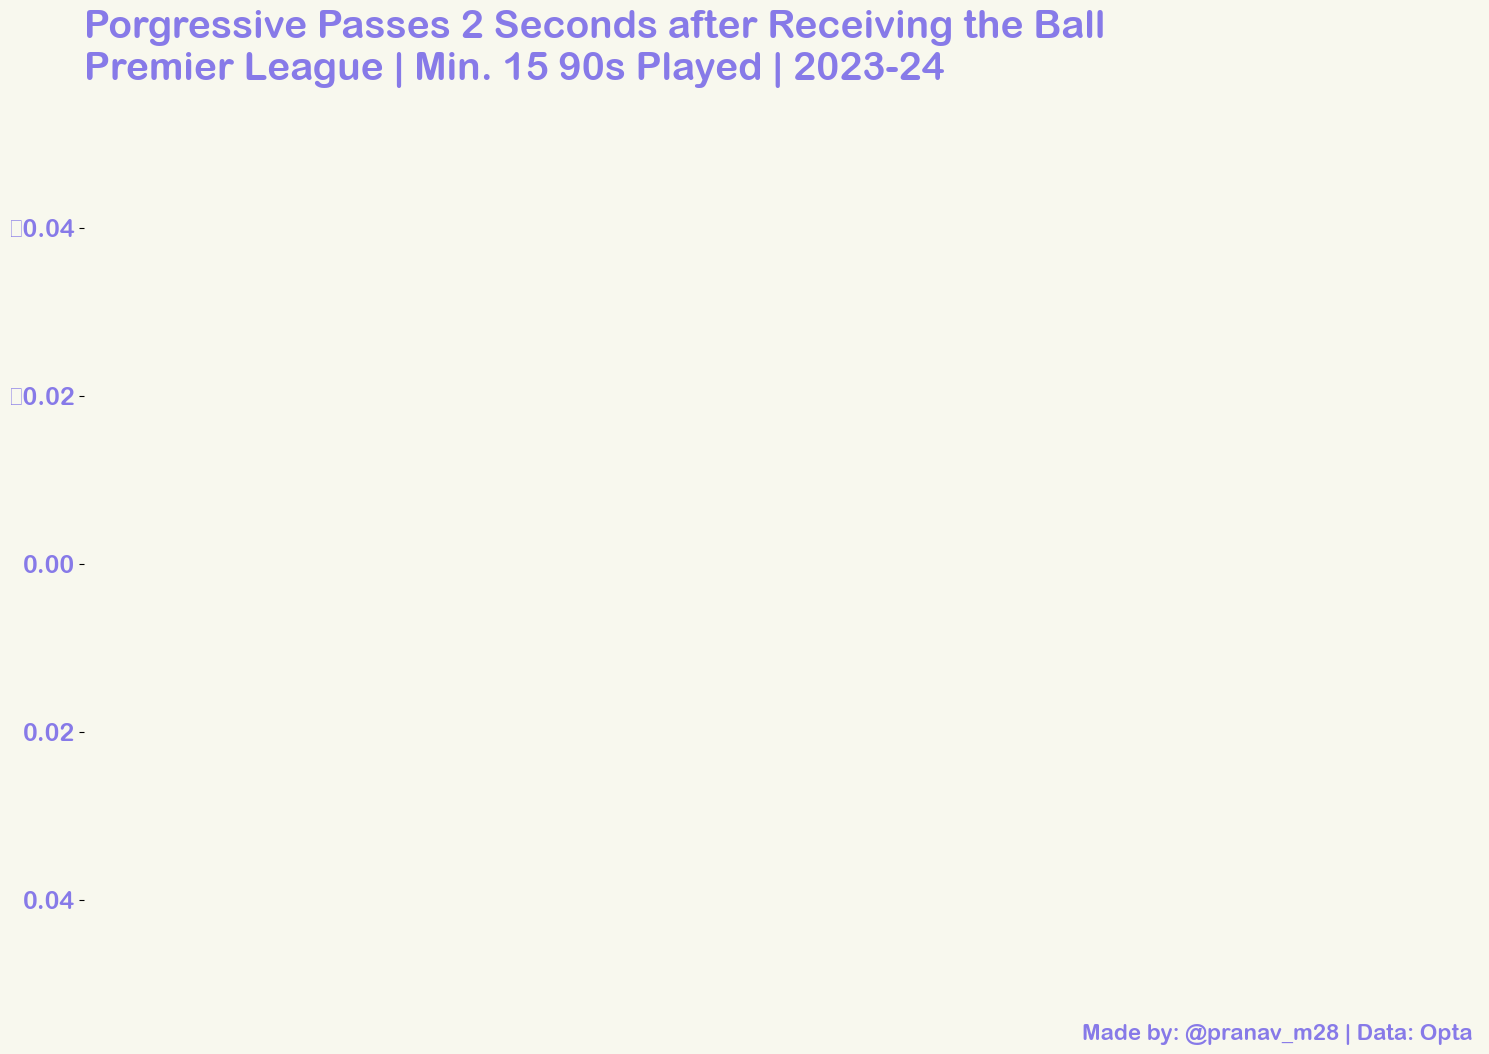

In [301]:
from matplotlib.font_manager import FontProperties
# Create the plot with the specified background color
fig, ax = plt.subplots(figsize=(18, 12))
fig.patch.set_facecolor('#f8f8ee')
ax.set_facecolor('#f8f8ee')

bars = ax.barh(disp['player'], disp['prog_pass_2_sec_p90'], color='#877ae8', height=0.65)

# Set the title and labels with custom color
ax.text(0.0, 1.1, 'Porgressive Passes 2 Seconds after Receiving the Ball\nPremier League | Min. 15 90s Played | 2023-24', font='Arial Rounded MT Bold', fontsize=28,
        color='#877ae8', ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel('Ball Retention %', font='Arial Rounded MT Bold', fontsize=12, color='#877ae8')

# Add a line below the title
#ax.axhline(y=-1.0, color='white', linewidth=1.5, alpha=0.5)  

# Set the font properties for player names and percentage labels
font_prop = FontProperties(family='Arial Rounded MT Bold', size=18)

# Add annotations with custom color and font properties
for bar in bars:
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.1f}', 
            va='center', ha='left', fontsize=18, color='#877ae8', fontproperties=font_prop)

# Invert the y-axis to have the player with the highest retention at the top
ax.invert_yaxis()

# Remove the x-axis numbers and ticks, but keep the player names on the y-axis
ax.tick_params(bottom=False, labelbottom=False)
ax.xaxis.set_visible(False)  # This removes the x-axis numbers

# Customize the y-axis tick labels
for tick in ax.get_yticklabels():
    tick.set_fontproperties(font_prop)
    tick.set_color('#877ae8')

# Remove the spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Add text for author and data source on the bottom right corner
ax.text(0.995, -0.02, 'Made by: @pranav_m28 | Data: Opta', font='Arial Rounded MT Bold',color='#877ae8', fontsize=16,
        ha='right', va='bottom', transform=ax.transAxes)


#plt.savefig("PP90 TTRP2 PL.png" , dpi=300, bbox_inches='tight')

# Display the plot
plt.show()